# Figure 5

In [1]:
import sys
sys.path.insert(1, '../../code/scripts')

In [2]:
## Basics
import numpy as np
import pandas as pd
import glob
import mdtraj as md
import random
from scipy import stats
from scipy.special import logit
from scipy.stats import mannwhitneyu
from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF

## Bio functions
from Bio import AlignIO
from Bio import SeqIO

## Local functions
import sys
sys.path.append("../code/scripts")
import alignment_quality as aq
import chargepatterns as cp
import composition as comp
import crutil
import fractional_charge as fc

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

## Set seed for consistency
### In the future when writing code with random remember to use new methods which explicitly create generators
seed = 212121

In [3]:
def comp_to_dict(c):
    d = {}
    for i,aa in enumerate(comp.aas):
        d[aa] = c[i]
    return d

## A

In [4]:
df = pd.read_csv('../data/aln_quality/aln_quality_hits.csv')
df_random = pd.read_csv('../data/aln_quality/aln_quality_random.csv')
df_disprot = pd.read_csv('../data/aln_quality/aln_quality_disprot.csv')

In [5]:
hits_aq = np.asarray(df['gappiness'].tolist())
idr_aq = np.asarray(df_disprot['gappiness'].tolist())
rand_aq = np.asarray(df['gappiness_null'].tolist())
rand_aq2 = np.asarray(df_random['gappiness'].tolist())

In [6]:
hits_sd = np.asarray(df['seq_div'].tolist())
idr_sd = np.asarray(df_disprot['seq_div'].tolist())
rand_sd = np.asarray(df['seq_div_null'].tolist())
rand_sd2 = np.asarray(df_random['seq_div'].tolist())

In [7]:
mannwhitneyu(hits_aq, rand_aq)

MannwhitneyuResult(statistic=357281.0, pvalue=0.0007201512387243321)

In [8]:
mannwhitneyu(hits_sd, rand_sd)

MannwhitneyuResult(statistic=410523.0, pvalue=1.2083259040938336e-19)

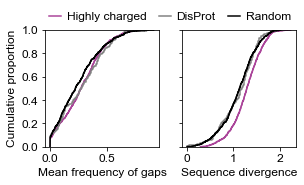

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(4.5,2.15))
ax1, ax2 = axes[0], axes[1]

sns.ecdfplot(hits_aq, color=cscheme['cr'],
             label='Highly charged', ax=ax1)
sns.ecdfplot(idr_aq, color=cscheme['dis'],
             label='DisProt', ax=ax1)
sns.ecdfplot(rand_aq, color=cscheme['null'],
             label='Random', ax=ax1)
ax1.set_xlabel('Mean frequency of gaps')
ax1.set_ylabel('Cumulative proportion')
ax1.set_yticks(np.arange(0, 1.1, 0.2))

sns.ecdfplot(hits_sd, color=cscheme['cr'], 
             label='Highly charged', ax=ax2)
sns.ecdfplot(idr_sd, color=cscheme['dis'], 
             label='DisProt', ax=ax2)
sns.ecdfplot(rand_sd, color=cscheme['null'],
             label='Random', ax=ax2)
ax2.set_xlabel('Sequence divergence')

ax1.legend(ncol=3, frameon=False, handletextpad=0.5, handlelength=1, columnspacing=1,
           bbox_to_anchor=(2.25, 1.25))
plt.savefig('./plots/Figure5A.png', dpi=300, bbox_inches='tight')
plt.show()

## B

In [10]:
aybrah = ['Rhodotorula graminis',
        'Saitoella complicata',
        'Schizosaccharomyces pombe',
        'Aspergillus niger',
        'Neurospora crassa',
        'Trichoderma reesei',
        'Lipomyces starkeyi',
        'Yarrowia lipolytica',
        'Blastobotrys adeninivorans',
        'Nadsonia fulvescens',
        'Ascoidea rubescens',
        'Pachysolen tannophilus',
        'Komagataella phaffii',
        'Kuraishia capsulata',
        'Ogataea arabinofermentans',
        'Ogataea parapolymorpha',
        'Dekkera bruxellensis',
        'Pichia membranifaciens',
        'Pichia kudriavzevii',
        'Babjeviella inositovora',
        'Metschnikowia bicuspidata',
        'Meyerozyma guilliermondii',
        'Debaryomyces hansenii',
        'Scheffersomyces stipitis',
        'Spathaspora passalidarum',
        'Wickerhamomyces anomalus',
        'Cyberlindnera jadinii',
        'Hanseniaspora valbyensis',
        'Kluyveromyces lactis',
        'Lachancea thermotolerans',
        'Zygosaccharomyces rouxii',
        'Saccharomyces cerevisiae',
        'Vanderwaltozyma polyspora']

In [11]:
AA_groups = {'charged': ['R', 'K', 'D', 'E'],
             'polar': ['Q', 'N', 'S', 'T', 'G', 'H'],
             'nonpolar': ['M', 'V', 'I', 'L'],
             'aromatic': ['F', 'Y', 'W'],
             'small': ['P', 'A', 'C']}

In [12]:
comp_dict = {}
for species in aybrah:
    name = species.split(' ')
    filepath = '../data/ref_proteomes/' + name[0] + '_' + name[1] + '.fasta'
    prot = []
    for record in SeqIO.parse(filepath, "fasta"):
        prot.append(record)
    
    c = np.zeros(20)
    for orf in prot:
        seq = str(orf.seq).replace('*', '').replace('X', '')
        c = np.add(c, comp.get_composition(seq, comp.aas))
    c = np.divide(c, len(prot))
    d = comp_to_dict(c)
    comp_dict[species] = d

In [13]:
df_dict = []
for species in aybrah:
    c = comp_dict[species]
    for group, AAs in AA_groups.items():
        rv = {}
        rv['AA_group'] = group
        rv['proportion'] = 0
        for AA in AAs:
            rv['proportion'] += c[AA]
        rv['log.odds'] = logit(rv['proportion'])
        df_dict.append(rv)

In [14]:
df = pd.DataFrame.from_records(df_dict)

In [15]:
df_agg = df.groupby('AA_group').agg(["var"]).reset_index()
df_agg

,AA_group,proportion,log.odds
,,var,var
0,aromatic,0.000036,0.006177
1,charged,0.000058,0.001766
2,nonpolar,0.000081,0.002603
3,polar,0.000071,0.001533
4,small,0.000538,0.040027


In [16]:
sorter = ['charged', 'polar', 'nonpolar', 'aromatic', 'small']

In [17]:
df_agg.AA_group = df.AA_group.astype("category")
df_agg.AA_group.cat.set_categories(sorter, inplace=True)

/Users/rosalindpan/opt/anaconda3/envs/env_hcr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


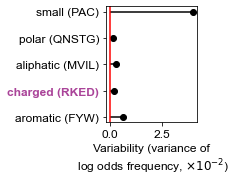

In [18]:
fig, ax = plt.subplots(figsize=(3,2.7))

ax.hlines(y=range(1,6), xmin=0, xmax=df_agg.iloc[:, 2]*1e2, color='black')
ax.plot(df_agg.iloc[:, 2]*1e2, range(1,6), "o", color='black')
ax.axvline(0, color='red')

ax.set_yticks(range(1, 6))
ax.set_yticklabels(['aromatic (FYW)', 'charged (RKED)', 'aliphatic (MVIL)', 'polar (QNSTG)', 'small (PAC)'])
plt.xlabel('Variability (variance of\n log odds frequency, $\\times 10^{-2}$)')

plt.gca().get_yticklabels()[1].set_color(cscheme['cr'])
plt.gca().get_yticklabels()[1].set_fontweight('bold')

plt.tight_layout()
plt.savefig('./plots/Figure5B.png', dpi=300, bbox_inches='tight')
plt.show()

## C

In [19]:
# Data and filepaths
df = pd.read_csv("../data/charged_regions/cr_trimmed_filtered_goodmsa.csv", comment='#')

aybrah_path = '/Users/rosalindpan/drummondlab/hcrpaper_data/aybrah-all/'

In [20]:
# Helper functions

def filter_msa(msa, cutoff, how="length"):
    """
    Given an msa, filter out all the entries that are less than a certain length.
    """
    filtered_msa = []
    for record in msa:
        rlen = len(str(record.seq).replace('-', ''))
        if rlen > cutoff:
            filtered_msa.append(record)
            
    return(filtered_msa)

def COV(x, absolute=True):
    """
    Given a interable of values, return the coefficient of variation of those values.
    """
    std = np.sqrt(np.nanvar(x))
    if not absolute:
        return(std / np.nanmean(x))
    else:
        return(std / np.abs(np.nanmean(x)))

In [21]:
def compute_region_fcr(msa):
    """
    Given an msa, extract the mean fraction of charged residues (FCR) of all the sequences in the msa
    """
    fcrs = []
    for record in msa:
        seq = str(record.seq).replace('-',"")
        fcrs.append(cp.fraction_charged(seq))
    return np.mean(fcrs)

def compute_region_fcr_var(msa, cov=False):
    """
    Given an msa, extract the variance in the fraction of charged residues (FCR) of all the sequences in the msa
    """
    fcrs = []
    for record in msa:
        seq = str(record.seq).replace('-',"")
        fcrs.append(cp.fraction_charged(seq))
    if not cov:
        return np.var(fcrs)
    else:
        return COV(fcrs)
    
def get_row_charge_props(row, filter_cutoff=30):
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    # Read MSA for the orf in question
    msa = AlignIO.read(open(aybrah_path+str(orf)+'-aybrah.fa'), "fasta")
    # Get just the region in question
    region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
    # Filter the msa for very short and empty regions
    region_msa = filter_msa(region_msa, cutoff=filter_cutoff)
    msa_len = len(region_msa)
    if msa_len < 10:
        out = np.empty(3)
        out[:] = np.NaN
        return pd.Series(out)
    
    # Calculate charge properties
    region_mean_fcr = compute_region_fcr(region_msa)
    region_fcr_var = compute_region_fcr_var(region_msa)
    region_fcr_cov = compute_region_fcr_var(region_msa, cov=True)
    
    return pd.Series([region_mean_fcr, region_fcr_var, region_fcr_cov])

In [22]:
newcols = df.apply(get_row_charge_props, axis=1)
newcols.columns = ['aybrah.mean.fcr', 'aybrah.fcr.var', 'aybrah.fcr.cov']
newdf = df.join(newcols)
newdf.head()

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,uni_id,orf_label,kappa,aybrah.mean.fcr,aybrah.fcr.var,aybrah.fcr.cov
0,YAL011W,SWC3,626,5,53,RTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDDAYDEVGND,49,0.017593,0.591837,P31376,verified,0.539053,0.347933,0.016456,0.368693
1,YAL011W,SWC3,626,169,261,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,93,0.052936,0.559140,P31376,verified,0.098538,0.414206,0.020280,0.343808
2,YAL011W,SWC3,626,361,424,KTAATEPEPKKADDENAEKQQSKEAKTTAESTQVDVKKEEEDVKEK...,64,0.007812,0.500000,P31376,verified,0.089231,0.391627,0.016703,0.330008
3,YAL011W,SWC3,626,470,525,KSVVEFLEDTDEIIISWIVIHNSKEIEKFKTKKIKAKLKADQKLNK...,56,0.000714,0.428571,P31376,verified,0.265395,0.461596,0.007704,0.190149
4,YAL013W,DEP1,406,84,159,ESLKRPHEDEKEAIDEAKKMKVPGENEDESKEEEKSQELEEAIDSK...,76,0.138444,0.592105,P31385,verified,0.219047,0.502212,0.008961,0.188490


In [23]:
verified_orfs_with_msa = pd.read_csv('../data/sc_orfs/verified_orfs_with_msa.csv')
valid_orfs = verified_orfs_with_msa['systematic_name'].tolist()

np.random.seed(seed)

def extract_random_region_from_proteome(fdir, regionlen, valid_orfs):
    msa = None
    cnt = 0
    while msa is None:
        orf_i = random.randrange(len(valid_orfs))
        orf = valid_orfs[orf_i]
        msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        if len(msa[0].seq) <= regionlen:
            msa = None
        cnt += 1
        if cnt >= 20:
            print(regionlen)
    starti = random.randrange(len(msa[0].seq) - regionlen)
    random_msa = msa[:, starti:(starti + regionlen)]    
    return random_msa

ranges_dict = {}
for index, row in df.iterrows():
    orf = row['orf']
    msa = AlignIO.read(open(aybrah_path+str(orf)+'-aybrah.fa'), "fasta")
    if orf not in ranges_dict:
        ranges_dict[orf] = []
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    msa_left_bound, msa_right_bound = aq.get_region_range(msa, left_bound, right_bound, refseq=refseq)
    ranges_dict[orf].append((msa_left_bound, msa_right_bound))

In [24]:
# add dist of randomly draw regions msas to above
np.random.seed(seed)
fcr_random = []

for k,v in ranges_dict.items():
    for charged_region in v:
        regionlen = charged_region[1] - charged_region[0] + 1
        
        # Draw a random msa and ensure there is an S. cer sequence in it
        redraw = True
        while redraw:
            #random_msa = extract_random_region_from_proteome(fdir, regionlen, valid_orfs)
            length = 0
            while length < 10:
                random_msa = extract_random_region_from_proteome(aybrah_path, regionlen, valid_orfs)
                # Filter out empty and very short sequences as we did for the charged regions themselves
                random_msa = filter_msa(random_msa, 25)
                # Calculate how many sequences are in the resulting alignment and redraw if there are fewer than the cutoff
                length = len(random_msa)
            for record in random_msa:
                if record.id == "Saccharomyces":
                    redraw=False
                    refseq=str(record.seq).replace("-", "")
        
        random_fcr = compute_region_fcr(random_msa)
        fcr_random.append(random_fcr)

In [25]:
ecdf = ECDF(fcr_random)

mindiff = 1e99
midpoint = 0
for i in np.arange(0, 0.4, 1e-6):
    res = ecdf(i)
    diff = abs(res - 0.5)
    if diff < mindiff:
        mindiff = diff
        midpoint = i

std = np.sqrt(np.var(fcr_random))

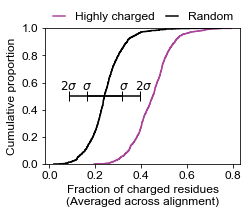

In [26]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.ecdfplot(data=newdf, x='aybrah.mean.fcr', color = cscheme['cr'],
             label = 'Highly charged', ax=ax)
sns.ecdfplot(fcr_random, color=cscheme['null'],
             label='Random', ax=ax)
ax.errorbar(midpoint, 0.5, xerr=std, color=cscheme['null'], capsize=5)
ax.errorbar(midpoint, 0.5, xerr=2*std, color=cscheme['null'], capsize=5)
ax.annotate(xy=(0.14, 0.55), text='$\sigma$')
ax.annotate(xy=(0.045, 0.55), text='$2\sigma$')
ax.annotate(xy=(0.305, 0.55), text='$\sigma$')
ax.annotate(xy=(0.375, 0.55), text='$2\sigma$')

plt.xlabel("Fraction of charged residues\n(Averaged across alignment)")
plt.ylabel("Cumulative proportion")
plt.legend(ncol=2, bbox_to_anchor=(1.02, 1.2), handlelength=1,
           columnspacing=1, frameon=False)
plt.savefig('./plots/Figure5C.png', dpi=300, bbox_inches='tight')
plt.show()

## D

In [27]:
enriched_data_path = "../../data/null-regions-output/trimmed/"

In [28]:
def compute_region_enriched_fraction(msa, target_aas):
    """
    Given an msa, extract the mean fraction of amino acids in a subset (target_aaas)
    for each sequences in the msa and return the mean
    """
    fracs = []
    for record in msa:
        seq = str(record.seq).replace('-',"")
        fracs.append(fc.get_enriched_fraction(seq, target_aas))
    return np.mean(fracs)

def read_and_filter_enrichment_data(fdir, file):
    data = pd.read_csv(file, comment="#")
    
    # # Filter MSA
    wrong_seq = []
    for index, row in data.iterrows():
        orf = row['orf']
        try:
            msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        # These are all empty / not in the Aybrah database
        except ValueError:
            wrong_seq.append(index)
            continue       
        contains_seq = False
        for record in msa:
            seq = crutil.remove_gaps(record.seq)
            if row['region.seq'] in seq:
                contains_seq = True
        if not contains_seq:
            wrong_seq.append(index)

    data.drop(data.index[wrong_seq], inplace=True)
    return data

def get_row_comp_conservation(row, target_aas, filter_cutoff=30):
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    # Read MSA for the orf in question
    fdir = '/Users/rosalindpan/drummondlab/hcrpaper_data/aybrah-all/'
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    # Get just the region in question
    # There are a small number of problematic sequences where the alignment boundaries are incorrect
    # This skips these; I still don't understand why they happen
    try:
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
    except KeyError:
        return(np.nan)
    # Filter the msa for very short and empty regions
    region_msa = filter_msa(region_msa, cutoff=filter_cutoff)

    region_enrichment = compute_region_enriched_fraction(region_msa, target_aas)
    
    return pd.Series(region_enrichment)

def get_comp(seq, states):
    dcomp = {}
    for state in states:
        dcomp[state] = 0
    for aa in seq:
        dcomp[aa] += 1
    comp = []
    for k,v in dcomp.items():
        comp.append(v / len(seq))
    return comp

def get_proteome_freqs(prot_filepath):
    """
    Given a .fa formattted proteome file (located at prot_filepath), generate a frequency vector of the natural 20 amino acids (in alphabetical order)
    """
    scerprot = []
    for record in SeqIO.parse(prot_filepath, "fasta"):
        scerprot.append(record)
    
    scercomp = np.zeros(20)
    for orf in scerprot:
        seq = str(orf.seq).replace('*', '')
        scercomp = np.add(scercomp, get_comp(seq, comp.aas))
    scercomp = np.divide(scercomp, len(scerprot))

    return(dict(zip(comp.aas, scercomp)))

def scale_to_unit(value, zer_val, one_val):
    """
    Given a value (float), convert to a scaled value within a given range onto the 0->1 scale.
    """
    span = one_val - zer_val
    scaled_value = (value-zer_val) / span
    return scaled_value

In [29]:
aa_freqs = get_proteome_freqs("../data/ref_proteomes/Saccharomyces_cerevisiae.fasta")

In [68]:
## Only uncomment if you want to regenerate data -- it takes a long time!

files = glob.glob(enriched_data_path+"*.csv")

all_drifts = []

for f, file in enumerate(files):
    if f % 5 == 0:
        print("Processing file {} / {}".format(f, len(files)))
    data = read_and_filter_enrichment_data(file)
    targets = list(data.keys()[-1][-4:])
    try:
        data["aybrah.avg.enrichment"] = data.apply(get_row_comp_conservation, args=(targets, ), axis=1)
    except KeyError:
        print(file)
        continue

    proteome_freq = np.sum([aa_freqs[aa] for aa in targets])
    enriched_freq = np.nanmean(data["fraction.enriched.{}".format(''.join(targets))])
    scaled_drift = scale_to_unit(np.nanmean(data['aybrah.avg.enrichment']), proteome_freq, enriched_freq)
    all_drifts.append(1-scaled_drift)

In [30]:
#np.savetxt("../../data/null-regions-output/trimmed/all_mean_drift_values.npy", all_drifts)
to_plot = np.loadtxt("../data/null-regions-output/trimmed/all_mean_drift_values.npy")

In [31]:
#calculate charge drift
fdir = '/Users/rosalindpan/drummondlab/hcrpaper_data/aybrah-all/'
data = read_and_filter_enrichment_data(fdir, "../data/charged_regions/cr_trimmed_filtered.csv")
targets = ["E", "R", "K", "D"]
data["aybrah.avg.enrichment"] = data.apply(get_row_comp_conservation, args=(targets, ), axis=1)
print(np.nanmean(data['aybrah.avg.enrichment']))

proteome_freq = np.sum([aa_freqs[aa] for aa in targets])
enriched_freq = np.nanmean(data["frac.charge"])
charged_drift = scale_to_unit(np.nanmean(data['aybrah.avg.enrichment']), proteome_freq, enriched_freq)

/Users/rosalindpan/opt/anaconda3/envs/env_hcr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rosalindpan/opt/anaconda3/envs/env_hcr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.44761022025899866


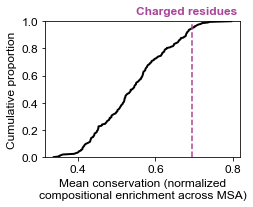

In [32]:
# Another (inverse) version with different labels
fig, ax = plt.subplots(figsize=(3.5,2.5))

# I am doing 1- the value here because I already inverted them while saving, but I actually want the raw value
# (more intuitive that higher=more conservation)
ax.plot(np.sort(1-to_plot), np.linspace(0, 1, len(to_plot)), linewidth=2, color = 'black')

ax.annotate('Charged residues', weight='bold',
            xy=(0.55, 1.05), annotation_clip=False, color=cscheme["cr"])
ax.axvline(charged_drift, linestyle='--', color=cscheme["cr"])
ax.set_ylim(0, 1)

#ax.annotate('Charged\namino acids',
#            xy=(1-0.24, 0.98), xycoords='data', size=14, weight='bold',
#            xytext=(0.45, 0.95), textcoords='data',
#            arrowprops=dict(color=cscheme['cr'], arrowstyle='-|>', connectionstyle="arc3,rad=-0.2"),
#            horizontalalignment='center', verticalalignment='top', color=cscheme["cr"])
plt.xlabel("Mean conservation (normalized\ncompositional enrichment across MSA)")
plt.ylabel("Cumulative proportion")
plt.savefig('./plots/Figure5D.png', dpi=300, bbox_inches='tight')
plt.show()